# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import random
import sys
import os
import logging

import optuna

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import mean_absolute_error, mean_squared_error

from typing import Optional

sys.path.append("../../src")
sys.path.append("../palm-tree")

import embedder
import models
import utils
import dataset

# Data

We should firstly parse the sample basic block data, or load it from pickle if the parsed data have been saved.
The preprocessing steps are based on data analysis done in the data exploration notebook

In [3]:
data_files = os.listdir("../../dataset/bb_data/")

if "good_dataset.pkl" not in data_files:
    result_files = [f for f in os.listdir("../../../good_dataset/") if f.endswith("results")] 
    #program_data_df = {}
    data_df = pd.DataFrame()

    for file in result_files:
        file_df = utils.read_bb_data(f"../../../good_dataset/{file}/breaker_code.txt", f"../../../good_dataset/{file}/breaker_final_energy.txt")
        file_df = utils.preprocess_bb_df(file_df)
        #program_data_df[file] = file_df
        data_df = pd.concat([data_df, file_df], ignore_index=True)
else:
    data_df = pd.read_pickle("../../dataset/bb_data/good_dataset.pkl")

if "bb_embeddings" not in data_df.columns:
    data_df["bb_embeddings"] = data_df.bb.apply(lambda x: embedder.encode(x))
    data_df.to_pickle("../../dataset/bb_data/good_dataset.pkl")

In [4]:
data_df.head(5)

,bb,energy,bb_embeddings
0,[movl $0x0],0.645165,"[[1.0268462, 0.028481035, 2.7335312, 0.5859081..."
1,"[callq, pushq %rbp, mov %rsp %rbp]",2.910575,"[[0.11681142, -0.7584041, 2.0799158, 0.3227231..."
2,"[popq %rbp, retq]",0.997157,"[[1.0268458, 0.028480439, 2.7335315, 0.5859076..."
3,[movl $0x0],0.664772,"[[1.0268462, 0.028481035, 2.7335312, 0.5859081..."
4,"[cmpl $0x64, jnl 0x2c]",1.400952,"[[1.0268458, 0.028480439, 2.7335315, 0.5859076..."


Pytorch custom dataset

In [5]:
def get_data_dict(
    data_df: pd.DataFrame,
    split: float = 0.9,
    mean: bool = False,
    batch_size: int = 32,
    random_state: Optional[int] = None,
) -> dict:

    split = 0.9
    data_df = data_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    bb_df_train = data_df[: int(split * len(data_df))]
    bb_df_val = data_df[int(split * len(data_df)) :]

    train_data = dataset.EnergyPredictionDataset(bb_df_train, mean=mean)
    if mean:
        train_loader = DataLoader(
            train_data, batch_size=batch_size, shuffle=False, drop_last=True
        )
    else:
        train_loader = DataLoader(
            train_data,
            batch_size=batch_size,
            shuffle=False,
            drop_last=True,
            collate_fn=utils.collate_fn,
        )

    val_data = dataset.EnergyPredictionDataset(bb_df_val, mean=mean)
    if mean:
        val_loader = DataLoader(
            val_data, batch_size=batch_size, shuffle=False, drop_last=True
        )
    else:
        val_loader = DataLoader(
            val_data,
            batch_size=batch_size,
            shuffle=False,
            drop_last=True,
            collate_fn=utils.collate_fn,
        )

    data_loaders = {
        "train_df": bb_df_train,
        "val_df": bb_df_val,
        "train_loader": train_loader,
        "val_loader": val_loader,
    }

    return data_loaders

In [6]:
class EarlyStopper:
    def __init__(self, patience: int = 5, min_delta: float = 0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss: float):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

# LSTM Model

In [6]:
class LSTM_Regressor(nn.Module):
    def __init__(
        self,
        emb_size: int,
        hidden_size: int = 16,
        num_layers: int = 2,
        dense_size: int = 128,
    ) -> None:
        super().__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size

        if self.num_layers > 1:
            lstm_dropout = 0.1
        else:
            lstm_dropout = 0

        self.lstm = nn.LSTM(
            input_size=emb_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=lstm_dropout,
        )

        self.dense = nn.Linear(hidden_size, dense_size)
        self.dropout = nn.Dropout(0.1)
        self.smaller_dense = nn.Linear(dense_size, 16)
        self.regressor = nn.Linear(16, 1)

    def forward(self, x, hidden):

        batch_size = x.size(0)

        lstm_out, hidden_state = self.lstm(x, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_size)

        out = self.dense(lstm_out)
        out = self.dropout(out)
        out = self.smaller_dense(out)
        out = self.regressor(out)

        out = out.view(batch_size, -1)
        out = out[:, -1]

        return out, hidden_state

    def init_hidden(self, batch_size):

        hidden = (
            torch.zeros((self.num_layers, batch_size, self.hidden_size)).cuda(),
            torch.zeros((self.num_layers, batch_size, self.hidden_size)).cuda(),
        )

        return hidden

## Training Function

In [7]:
def train_lstm_model(
    model: LSTM_Regressor,
    train_loader: DataLoader,
    val_loader: DataLoader,
    lr: float = 1e-2,
    batch_size: int = 32,
    epochs: int = 100,
    verbose: bool = False,
    early_stopping: bool = True,
) -> dict:

    if early_stopping:
        early_stopper = EarlyStopper()

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr, weight_decay=1e-4)

    model.cuda()

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        hidden_state = model.init_hidden(batch_size=batch_size)
        losses = []
        for embeddings, _, labels in train_loader:

            embeddings = embeddings.cuda()
            labels = labels.cuda()

            hidden_state = tuple([each.data for each in hidden_state])

            output, hidden_state = model(embeddings, hidden_state)
            loss = criterion(output.squeeze(), labels.float())

            optimizer.zero_grad()
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
            optimizer.step()
            losses.append(loss.item())

        val_h = model.init_hidden(batch_size)
        val_loss = []
        model.eval()
        for embeddings, _, labels in val_loader:

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history

            embeddings, labels = embeddings.cuda(), labels.cuda()
            output, val_h = model(embeddings, val_h)
            v_loss = criterion(output.squeeze(), labels.float())

            val_loss.append(v_loss.item())

        if verbose:
            print(
                f"Epoch: {epoch+1}/{epochs}, MSE Train Loss: {round(np.mean(losses), 5)}, MSE Val Loss: {round(np.mean(val_loss), 5)}"
            )

        train_losses.append(np.mean(losses))
        val_losses.append(np.mean(val_loss))

        if early_stopping:
            early_stopper.early_stop(val_losses[-1])

    model_training = {
        "model": model,
        "train_loss": train_losses,
        "val_loss": val_losses,
        "epochs_trained": epoch,
    }

    return model_training


## Optuna Trials

In [14]:
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "lstm-regression-study-good-dataset-2nd"
storage_name = f"sqlite:////Users/thodo/Documents/σχολη/diplomatiki/optuna-studies/lstm-regression-study-good-dataset.db"
study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True, direction="minimize")

[I 2023-01-08 17:10:41,652] Using an existing study with name 'lstm-regression-study-good-dataset-2nd' instead of creating a new one.


Using an existing study with name 'lstm-regression-study-good-dataset-2nd' instead of creating a new one.


In [9]:
def objective(trial):

    lstm_layers = trial.suggest_int("lstm_layers", 1, 5)
    hidden_size = trial.suggest_int("hidden_size", 8, 128)
    dense_size = trial.suggest_int("dense_size", 16, 256)
    batch_size_exp = trial.suggest_int("batch_size_exp", 3, 7)
    lr_exp = trial.suggest_int("learning_rate_exp", -4, -2)

    batch_size = 2**batch_size_exp
    lr = 10**lr_exp

    data_loaders = get_data_dict(data_df=data_df, mean=False, batch_size=batch_size)
    train_loader = data_loaders["train_loader"]
    val_loader = data_loaders["val_loader"]

    emb_size = next(iter(train_loader))[0].shape[-1]

    model = LSTM_Regressor(
        emb_size=emb_size,
        hidden_size=hidden_size,
        num_layers=lstm_layers,
        dense_size=dense_size,
    )
    train_results = train_lstm_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        lr=lr,
        epochs=200,
        batch_size=batch_size,
        early_stopping=True,
    )

    val_loss = train_results["val_loss"]

    return val_loss[-1]


study.optimize(objective, n_trials=100)

[I 2023-01-07 18:06:41,254] Trial 0 finished with value: 0.4079704567351762 and parameters: {'lstm_layers': 1, 'hidden_size': 30, 'dense_size': 74, 'batch_size_exp': 6, 'learning_rate_exp': -2}. Best is trial 0 with value: 0.4079704567351762.


Trial 0 finished with value: 0.4079704567351762 and parameters: {'lstm_layers': 1, 'hidden_size': 30, 'dense_size': 74, 'batch_size_exp': 6, 'learning_rate_exp': -2}. Best is trial 0 with value: 0.4079704567351762.


[I 2023-01-07 19:10:05,812] Trial 1 finished with value: 0.30612007344865966 and parameters: {'lstm_layers': 5, 'hidden_size': 107, 'dense_size': 30, 'batch_size_exp': 3, 'learning_rate_exp': -3}. Best is trial 1 with value: 0.30612007344865966.


Trial 1 finished with value: 0.30612007344865966 and parameters: {'lstm_layers': 5, 'hidden_size': 107, 'dense_size': 30, 'batch_size_exp': 3, 'learning_rate_exp': -3}. Best is trial 1 with value: 0.30612007344865966.


[I 2023-01-07 19:20:07,529] Trial 2 finished with value: 0.4655284241718404 and parameters: {'lstm_layers': 5, 'hidden_size': 51, 'dense_size': 107, 'batch_size_exp': 6, 'learning_rate_exp': -2}. Best is trial 1 with value: 0.30612007344865966.


Trial 2 finished with value: 0.4655284241718404 and parameters: {'lstm_layers': 5, 'hidden_size': 51, 'dense_size': 107, 'batch_size_exp': 6, 'learning_rate_exp': -2}. Best is trial 1 with value: 0.30612007344865966.


[I 2023-01-07 19:43:46,642] Trial 3 finished with value: 0.2718323342327913 and parameters: {'lstm_layers': 2, 'hidden_size': 27, 'dense_size': 89, 'batch_size_exp': 4, 'learning_rate_exp': -4}. Best is trial 3 with value: 0.2718323342327913.


Trial 3 finished with value: 0.2718323342327913 and parameters: {'lstm_layers': 2, 'hidden_size': 27, 'dense_size': 89, 'batch_size_exp': 4, 'learning_rate_exp': -4}. Best is trial 3 with value: 0.2718323342327913.


[I 2023-01-07 19:49:08,077] Trial 4 finished with value: 0.37938129025347095 and parameters: {'lstm_layers': 1, 'hidden_size': 85, 'dense_size': 103, 'batch_size_exp': 6, 'learning_rate_exp': -4}. Best is trial 3 with value: 0.2718323342327913.


Trial 4 finished with value: 0.37938129025347095 and parameters: {'lstm_layers': 1, 'hidden_size': 85, 'dense_size': 103, 'batch_size_exp': 6, 'learning_rate_exp': -4}. Best is trial 3 with value: 0.2718323342327913.


[I 2023-01-07 20:04:03,003] Trial 5 finished with value: 0.42976465313762857 and parameters: {'lstm_layers': 3, 'hidden_size': 74, 'dense_size': 70, 'batch_size_exp': 5, 'learning_rate_exp': -2}. Best is trial 3 with value: 0.2718323342327913.


Trial 5 finished with value: 0.42976465313762857 and parameters: {'lstm_layers': 3, 'hidden_size': 74, 'dense_size': 70, 'batch_size_exp': 5, 'learning_rate_exp': -2}. Best is trial 3 with value: 0.2718323342327913.


[I 2023-01-07 20:12:02,205] Trial 6 finished with value: 0.3601922157275326 and parameters: {'lstm_layers': 3, 'hidden_size': 121, 'dense_size': 95, 'batch_size_exp': 6, 'learning_rate_exp': -3}. Best is trial 3 with value: 0.2718323342327913.


Trial 6 finished with value: 0.3601922157275326 and parameters: {'lstm_layers': 3, 'hidden_size': 121, 'dense_size': 95, 'batch_size_exp': 6, 'learning_rate_exp': -3}. Best is trial 3 with value: 0.2718323342327913.


[I 2023-01-07 20:22:22,072] Trial 7 finished with value: 0.5599175392501596 and parameters: {'lstm_layers': 1, 'hidden_size': 100, 'dense_size': 237, 'batch_size_exp': 5, 'learning_rate_exp': -2}. Best is trial 3 with value: 0.2718323342327913.


Trial 7 finished with value: 0.5599175392501596 and parameters: {'lstm_layers': 1, 'hidden_size': 100, 'dense_size': 237, 'batch_size_exp': 5, 'learning_rate_exp': -2}. Best is trial 3 with value: 0.2718323342327913.


[I 2023-01-07 20:32:27,580] Trial 8 finished with value: 0.3671123586811017 and parameters: {'lstm_layers': 1, 'hidden_size': 53, 'dense_size': 26, 'batch_size_exp': 5, 'learning_rate_exp': -4}. Best is trial 3 with value: 0.2718323342327913.


Trial 8 finished with value: 0.3671123586811017 and parameters: {'lstm_layers': 1, 'hidden_size': 53, 'dense_size': 26, 'batch_size_exp': 5, 'learning_rate_exp': -4}. Best is trial 3 with value: 0.2718323342327913.


[I 2023-01-07 20:56:24,710] Trial 9 finished with value: 0.36285400001345564 and parameters: {'lstm_layers': 2, 'hidden_size': 61, 'dense_size': 33, 'batch_size_exp': 4, 'learning_rate_exp': -3}. Best is trial 3 with value: 0.2718323342327913.


Trial 9 finished with value: 0.36285400001345564 and parameters: {'lstm_layers': 2, 'hidden_size': 61, 'dense_size': 33, 'batch_size_exp': 4, 'learning_rate_exp': -3}. Best is trial 3 with value: 0.2718323342327913.


[I 2023-01-07 21:52:14,427] Trial 10 finished with value: 0.25717084527626555 and parameters: {'lstm_layers': 4, 'hidden_size': 11, 'dense_size': 164, 'batch_size_exp': 3, 'learning_rate_exp': -4}. Best is trial 10 with value: 0.25717084527626555.


Trial 10 finished with value: 0.25717084527626555 and parameters: {'lstm_layers': 4, 'hidden_size': 11, 'dense_size': 164, 'batch_size_exp': 3, 'learning_rate_exp': -4}. Best is trial 10 with value: 0.25717084527626555.


[I 2023-01-07 22:48:00,251] Trial 11 finished with value: 0.3186845796159385 and parameters: {'lstm_layers': 4, 'hidden_size': 8, 'dense_size': 180, 'batch_size_exp': 3, 'learning_rate_exp': -4}. Best is trial 10 with value: 0.25717084527626555.


Trial 11 finished with value: 0.3186845796159385 and parameters: {'lstm_layers': 4, 'hidden_size': 8, 'dense_size': 180, 'batch_size_exp': 3, 'learning_rate_exp': -4}. Best is trial 10 with value: 0.25717084527626555.


[I 2023-01-07 23:20:00,642] Trial 12 finished with value: 0.29525549950332736 and parameters: {'lstm_layers': 4, 'hidden_size': 8, 'dense_size': 149, 'batch_size_exp': 4, 'learning_rate_exp': -4}. Best is trial 10 with value: 0.25717084527626555.


Trial 12 finished with value: 0.29525549950332736 and parameters: {'lstm_layers': 4, 'hidden_size': 8, 'dense_size': 149, 'batch_size_exp': 4, 'learning_rate_exp': -4}. Best is trial 10 with value: 0.25717084527626555.


[I 2023-01-07 23:44:42,435] Trial 13 finished with value: 0.35925994348450957 and parameters: {'lstm_layers': 2, 'hidden_size': 33, 'dense_size': 181, 'batch_size_exp': 4, 'learning_rate_exp': -4}. Best is trial 10 with value: 0.25717084527626555.


Trial 13 finished with value: 0.35925994348450957 and parameters: {'lstm_layers': 2, 'hidden_size': 33, 'dense_size': 181, 'batch_size_exp': 4, 'learning_rate_exp': -4}. Best is trial 10 with value: 0.25717084527626555.


[I 2023-01-08 00:42:58,068] Trial 14 finished with value: 0.3387719403541777 and parameters: {'lstm_layers': 4, 'hidden_size': 28, 'dense_size': 158, 'batch_size_exp': 3, 'learning_rate_exp': -4}. Best is trial 10 with value: 0.25717084527626555.


Trial 14 finished with value: 0.3387719403541777 and parameters: {'lstm_layers': 4, 'hidden_size': 28, 'dense_size': 158, 'batch_size_exp': 3, 'learning_rate_exp': -4}. Best is trial 10 with value: 0.25717084527626555.


[I 2023-01-08 01:06:31,979] Trial 15 finished with value: 0.3432482292460238 and parameters: {'lstm_layers': 2, 'hidden_size': 24, 'dense_size': 216, 'batch_size_exp': 4, 'learning_rate_exp': -3}. Best is trial 10 with value: 0.25717084527626555.


Trial 15 finished with value: 0.3432482292460238 and parameters: {'lstm_layers': 2, 'hidden_size': 24, 'dense_size': 216, 'batch_size_exp': 4, 'learning_rate_exp': -3}. Best is trial 10 with value: 0.25717084527626555.


[I 2023-01-08 01:10:56,448] Trial 16 finished with value: 0.28667182606809277 and parameters: {'lstm_layers': 3, 'hidden_size': 43, 'dense_size': 130, 'batch_size_exp': 7, 'learning_rate_exp': -4}. Best is trial 10 with value: 0.25717084527626555.


Trial 16 finished with value: 0.28667182606809277 and parameters: {'lstm_layers': 3, 'hidden_size': 43, 'dense_size': 130, 'batch_size_exp': 7, 'learning_rate_exp': -4}. Best is trial 10 with value: 0.25717084527626555.


[I 2023-01-08 02:06:57,521] Trial 17 finished with value: 0.3287377549947897 and parameters: {'lstm_layers': 4, 'hidden_size': 16, 'dense_size': 192, 'batch_size_exp': 3, 'learning_rate_exp': -3}. Best is trial 10 with value: 0.25717084527626555.


Trial 17 finished with value: 0.3287377549947897 and parameters: {'lstm_layers': 4, 'hidden_size': 16, 'dense_size': 192, 'batch_size_exp': 3, 'learning_rate_exp': -3}. Best is trial 10 with value: 0.25717084527626555.


[I 2023-01-08 02:31:04,877] Trial 18 finished with value: 0.2807566892864893 and parameters: {'lstm_layers': 2, 'hidden_size': 42, 'dense_size': 123, 'batch_size_exp': 4, 'learning_rate_exp': -4}. Best is trial 10 with value: 0.25717084527626555.


Trial 18 finished with value: 0.2807566892864893 and parameters: {'lstm_layers': 2, 'hidden_size': 42, 'dense_size': 123, 'batch_size_exp': 4, 'learning_rate_exp': -4}. Best is trial 10 with value: 0.25717084527626555.


[I 2023-01-08 03:35:01,519] Trial 19 finished with value: 0.3646354740034909 and parameters: {'lstm_layers': 5, 'hidden_size': 18, 'dense_size': 252, 'batch_size_exp': 3, 'learning_rate_exp': -3}. Best is trial 10 with value: 0.25717084527626555.


Trial 19 finished with value: 0.3646354740034909 and parameters: {'lstm_layers': 5, 'hidden_size': 18, 'dense_size': 252, 'batch_size_exp': 3, 'learning_rate_exp': -3}. Best is trial 10 with value: 0.25717084527626555.


[I 2023-01-08 04:03:03,050] Trial 20 finished with value: 0.29377573585177924 and parameters: {'lstm_layers': 3, 'hidden_size': 40, 'dense_size': 59, 'batch_size_exp': 4, 'learning_rate_exp': -4}. Best is trial 10 with value: 0.25717084527626555.


Trial 20 finished with value: 0.29377573585177924 and parameters: {'lstm_layers': 3, 'hidden_size': 40, 'dense_size': 59, 'batch_size_exp': 4, 'learning_rate_exp': -4}. Best is trial 10 with value: 0.25717084527626555.


[I 2023-01-08 04:26:37,368] Trial 21 finished with value: 0.3413965888455403 and parameters: {'lstm_layers': 2, 'hidden_size': 41, 'dense_size': 129, 'batch_size_exp': 4, 'learning_rate_exp': -4}. Best is trial 10 with value: 0.25717084527626555.


Trial 21 finished with value: 0.3413965888455403 and parameters: {'lstm_layers': 2, 'hidden_size': 41, 'dense_size': 129, 'batch_size_exp': 4, 'learning_rate_exp': -4}. Best is trial 10 with value: 0.25717084527626555.


[I 2023-01-08 04:50:13,838] Trial 22 finished with value: 0.31639052222636965 and parameters: {'lstm_layers': 2, 'hidden_size': 69, 'dense_size': 119, 'batch_size_exp': 4, 'learning_rate_exp': -4}. Best is trial 10 with value: 0.25717084527626555.


Trial 22 finished with value: 0.31639052222636965 and parameters: {'lstm_layers': 2, 'hidden_size': 69, 'dense_size': 119, 'batch_size_exp': 4, 'learning_rate_exp': -4}. Best is trial 10 with value: 0.25717084527626555.


[I 2023-01-08 05:39:06,993] Trial 23 finished with value: 0.3359697763482609 and parameters: {'lstm_layers': 3, 'hidden_size': 17, 'dense_size': 157, 'batch_size_exp': 3, 'learning_rate_exp': -4}. Best is trial 10 with value: 0.25717084527626555.


Trial 23 finished with value: 0.3359697763482609 and parameters: {'lstm_layers': 3, 'hidden_size': 17, 'dense_size': 157, 'batch_size_exp': 3, 'learning_rate_exp': -4}. Best is trial 10 with value: 0.25717084527626555.


[I 2023-01-08 05:51:24,749] Trial 24 finished with value: 0.36123265077670413 and parameters: {'lstm_layers': 2, 'hidden_size': 55, 'dense_size': 89, 'batch_size_exp': 5, 'learning_rate_exp': -4}. Best is trial 10 with value: 0.25717084527626555.


Trial 24 finished with value: 0.36123265077670413 and parameters: {'lstm_layers': 2, 'hidden_size': 55, 'dense_size': 89, 'batch_size_exp': 5, 'learning_rate_exp': -4}. Best is trial 10 with value: 0.25717084527626555.


[I 2023-01-08 06:23:56,480] Trial 25 finished with value: 0.25548942384423967 and parameters: {'lstm_layers': 4, 'hidden_size': 37, 'dense_size': 149, 'batch_size_exp': 4, 'learning_rate_exp': -3}. Best is trial 25 with value: 0.25548942384423967.


Trial 25 finished with value: 0.25548942384423967 and parameters: {'lstm_layers': 4, 'hidden_size': 37, 'dense_size': 149, 'batch_size_exp': 4, 'learning_rate_exp': -3}. Best is trial 25 with value: 0.25548942384423967.


[I 2023-01-08 07:18:43,087] Trial 26 finished with value: 0.3196437732161333 and parameters: {'lstm_layers': 4, 'hidden_size': 21, 'dense_size': 195, 'batch_size_exp': 3, 'learning_rate_exp': -3}. Best is trial 25 with value: 0.25548942384423967.


Trial 26 finished with value: 0.3196437732161333 and parameters: {'lstm_layers': 4, 'hidden_size': 21, 'dense_size': 195, 'batch_size_exp': 3, 'learning_rate_exp': -3}. Best is trial 25 with value: 0.25548942384423967.


[I 2023-01-08 07:35:29,750] Trial 27 finished with value: 0.3792377673089504 and parameters: {'lstm_layers': 4, 'hidden_size': 35, 'dense_size': 143, 'batch_size_exp': 5, 'learning_rate_exp': -3}. Best is trial 25 with value: 0.25548942384423967.


Trial 27 finished with value: 0.3792377673089504 and parameters: {'lstm_layers': 4, 'hidden_size': 35, 'dense_size': 143, 'batch_size_exp': 5, 'learning_rate_exp': -3}. Best is trial 25 with value: 0.25548942384423967.


[I 2023-01-08 08:12:57,555] Trial 28 finished with value: 0.28928625708271705 and parameters: {'lstm_layers': 5, 'hidden_size': 80, 'dense_size': 169, 'batch_size_exp': 4, 'learning_rate_exp': -3}. Best is trial 25 with value: 0.25548942384423967.


Trial 28 finished with value: 0.28928625708271705 and parameters: {'lstm_layers': 5, 'hidden_size': 80, 'dense_size': 169, 'batch_size_exp': 4, 'learning_rate_exp': -3}. Best is trial 25 with value: 0.25548942384423967.


[I 2023-01-08 09:00:27,917] Trial 29 finished with value: 0.6912276092849966 and parameters: {'lstm_layers': 3, 'hidden_size': 10, 'dense_size': 83, 'batch_size_exp': 3, 'learning_rate_exp': -2}. Best is trial 25 with value: 0.25548942384423967.


Trial 29 finished with value: 0.6912276092849966 and parameters: {'lstm_layers': 3, 'hidden_size': 10, 'dense_size': 83, 'batch_size_exp': 3, 'learning_rate_exp': -2}. Best is trial 25 with value: 0.25548942384423967.


[I 2023-01-08 09:05:28,416] Trial 30 finished with value: 0.23924224078655243 and parameters: {'lstm_layers': 4, 'hidden_size': 28, 'dense_size': 214, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 30 with value: 0.23924224078655243.


Trial 30 finished with value: 0.23924224078655243 and parameters: {'lstm_layers': 4, 'hidden_size': 28, 'dense_size': 214, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 30 with value: 0.23924224078655243.


[I 2023-01-08 09:10:26,593] Trial 31 finished with value: 0.29295359201291027 and parameters: {'lstm_layers': 4, 'hidden_size': 29, 'dense_size': 224, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 30 with value: 0.23924224078655243.


Trial 31 finished with value: 0.29295359201291027 and parameters: {'lstm_layers': 4, 'hidden_size': 29, 'dense_size': 224, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 30 with value: 0.23924224078655243.


[I 2023-01-08 09:15:57,024] Trial 32 finished with value: 0.2575650197618148 and parameters: {'lstm_layers': 5, 'hidden_size': 26, 'dense_size': 199, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 30 with value: 0.23924224078655243.


Trial 32 finished with value: 0.2575650197618148 and parameters: {'lstm_layers': 5, 'hidden_size': 26, 'dense_size': 199, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 30 with value: 0.23924224078655243.


[I 2023-01-08 09:21:31,326] Trial 33 finished with value: 0.34339632663656683 and parameters: {'lstm_layers': 5, 'hidden_size': 47, 'dense_size': 208, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 30 with value: 0.23924224078655243.


Trial 33 finished with value: 0.34339632663656683 and parameters: {'lstm_layers': 5, 'hidden_size': 47, 'dense_size': 208, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 30 with value: 0.23924224078655243.


[I 2023-01-08 09:27:03,619] Trial 34 finished with value: 0.5775837714181227 and parameters: {'lstm_layers': 5, 'hidden_size': 36, 'dense_size': 202, 'batch_size_exp': 7, 'learning_rate_exp': -2}. Best is trial 30 with value: 0.23924224078655243.


Trial 34 finished with value: 0.5775837714181227 and parameters: {'lstm_layers': 5, 'hidden_size': 36, 'dense_size': 202, 'batch_size_exp': 7, 'learning_rate_exp': -2}. Best is trial 30 with value: 0.23924224078655243.


[I 2023-01-08 09:37:00,508] Trial 35 finished with value: 0.39208376024137526 and parameters: {'lstm_layers': 5, 'hidden_size': 23, 'dense_size': 229, 'batch_size_exp': 6, 'learning_rate_exp': -3}. Best is trial 30 with value: 0.23924224078655243.


Trial 35 finished with value: 0.39208376024137526 and parameters: {'lstm_layers': 5, 'hidden_size': 23, 'dense_size': 229, 'batch_size_exp': 6, 'learning_rate_exp': -3}. Best is trial 30 with value: 0.23924224078655243.


[I 2023-01-08 09:42:00,891] Trial 36 finished with value: 0.2848626931800562 and parameters: {'lstm_layers': 4, 'hidden_size': 60, 'dense_size': 174, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 30 with value: 0.23924224078655243.


Trial 36 finished with value: 0.2848626931800562 and parameters: {'lstm_layers': 4, 'hidden_size': 60, 'dense_size': 174, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 30 with value: 0.23924224078655243.


[I 2023-01-08 09:51:51,504] Trial 37 finished with value: 0.7978505117490011 and parameters: {'lstm_layers': 5, 'hidden_size': 16, 'dense_size': 250, 'batch_size_exp': 6, 'learning_rate_exp': -2}. Best is trial 30 with value: 0.23924224078655243.


Trial 37 finished with value: 0.7978505117490011 and parameters: {'lstm_layers': 5, 'hidden_size': 16, 'dense_size': 250, 'batch_size_exp': 6, 'learning_rate_exp': -2}. Best is trial 30 with value: 0.23924224078655243.


[I 2023-01-08 09:56:53,221] Trial 38 finished with value: 0.21516395141096675 and parameters: {'lstm_layers': 4, 'hidden_size': 30, 'dense_size': 163, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 38 finished with value: 0.21516395141096675 and parameters: {'lstm_layers': 4, 'hidden_size': 30, 'dense_size': 163, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 10:05:40,353] Trial 39 finished with value: 0.2645366659716648 and parameters: {'lstm_layers': 4, 'hidden_size': 48, 'dense_size': 111, 'batch_size_exp': 6, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 39 finished with value: 0.2645366659716648 and parameters: {'lstm_layers': 4, 'hidden_size': 48, 'dense_size': 111, 'batch_size_exp': 6, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 10:20:38,232] Trial 40 finished with value: 0.456496921894343 and parameters: {'lstm_layers': 3, 'hidden_size': 127, 'dense_size': 143, 'batch_size_exp': 5, 'learning_rate_exp': -2}. Best is trial 38 with value: 0.21516395141096675.


Trial 40 finished with value: 0.456496921894343 and parameters: {'lstm_layers': 3, 'hidden_size': 127, 'dense_size': 143, 'batch_size_exp': 5, 'learning_rate_exp': -2}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 10:25:38,977] Trial 41 finished with value: 0.29104993623845715 and parameters: {'lstm_layers': 4, 'hidden_size': 28, 'dense_size': 188, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 41 finished with value: 0.29104993623845715 and parameters: {'lstm_layers': 4, 'hidden_size': 28, 'dense_size': 188, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 10:30:35,670] Trial 42 finished with value: 0.21787791786824956 and parameters: {'lstm_layers': 4, 'hidden_size': 95, 'dense_size': 163, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 42 finished with value: 0.21787791786824956 and parameters: {'lstm_layers': 4, 'hidden_size': 95, 'dense_size': 163, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 10:35:30,079] Trial 43 finished with value: 0.2463857592905269 and parameters: {'lstm_layers': 4, 'hidden_size': 104, 'dense_size': 165, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 43 finished with value: 0.2463857592905269 and parameters: {'lstm_layers': 4, 'hidden_size': 104, 'dense_size': 165, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 10:40:24,937] Trial 44 finished with value: 0.27052630484104156 and parameters: {'lstm_layers': 4, 'hidden_size': 102, 'dense_size': 152, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 44 finished with value: 0.27052630484104156 and parameters: {'lstm_layers': 4, 'hidden_size': 102, 'dense_size': 152, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 10:49:23,346] Trial 45 finished with value: 0.32479930548545194 and parameters: {'lstm_layers': 4, 'hidden_size': 89, 'dense_size': 167, 'batch_size_exp': 6, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 45 finished with value: 0.32479930548545194 and parameters: {'lstm_layers': 4, 'hidden_size': 89, 'dense_size': 167, 'batch_size_exp': 6, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 10:54:19,002] Trial 46 finished with value: 0.29073289124404683 and parameters: {'lstm_layers': 4, 'hidden_size': 114, 'dense_size': 182, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 46 finished with value: 0.29073289124404683 and parameters: {'lstm_layers': 4, 'hidden_size': 114, 'dense_size': 182, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 10:58:35,875] Trial 47 finished with value: 0.2934989052660325 and parameters: {'lstm_layers': 3, 'hidden_size': 92, 'dense_size': 138, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 47 finished with value: 0.2934989052660325 and parameters: {'lstm_layers': 3, 'hidden_size': 92, 'dense_size': 138, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 11:07:33,699] Trial 48 finished with value: 0.24518226273357868 and parameters: {'lstm_layers': 4, 'hidden_size': 107, 'dense_size': 210, 'batch_size_exp': 6, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 48 finished with value: 0.24518226273357868 and parameters: {'lstm_layers': 4, 'hidden_size': 107, 'dense_size': 210, 'batch_size_exp': 6, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 11:16:28,726] Trial 49 finished with value: 0.3549495129024281 and parameters: {'lstm_layers': 4, 'hidden_size': 112, 'dense_size': 213, 'batch_size_exp': 6, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 49 finished with value: 0.3549495129024281 and parameters: {'lstm_layers': 4, 'hidden_size': 112, 'dense_size': 213, 'batch_size_exp': 6, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 11:25:24,081] Trial 50 finished with value: 0.27435270981753573 and parameters: {'lstm_layers': 4, 'hidden_size': 97, 'dense_size': 239, 'batch_size_exp': 6, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 50 finished with value: 0.27435270981753573 and parameters: {'lstm_layers': 4, 'hidden_size': 97, 'dense_size': 239, 'batch_size_exp': 6, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 11:30:20,018] Trial 51 finished with value: 0.21737849142621546 and parameters: {'lstm_layers': 4, 'hidden_size': 107, 'dense_size': 162, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 51 finished with value: 0.21737849142621546 and parameters: {'lstm_layers': 4, 'hidden_size': 107, 'dense_size': 162, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 11:35:15,899] Trial 52 finished with value: 0.3177548559272991 and parameters: {'lstm_layers': 4, 'hidden_size': 107, 'dense_size': 162, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 52 finished with value: 0.3177548559272991 and parameters: {'lstm_layers': 4, 'hidden_size': 107, 'dense_size': 162, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 11:39:35,230] Trial 53 finished with value: 0.2767170851721483 and parameters: {'lstm_layers': 3, 'hidden_size': 117, 'dense_size': 178, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 53 finished with value: 0.2767170851721483 and parameters: {'lstm_layers': 3, 'hidden_size': 117, 'dense_size': 178, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 11:44:30,232] Trial 54 finished with value: 0.39075939488761563 and parameters: {'lstm_layers': 4, 'hidden_size': 97, 'dense_size': 189, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 54 finished with value: 0.39075939488761563 and parameters: {'lstm_layers': 4, 'hidden_size': 97, 'dense_size': 189, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 11:49:25,988] Trial 55 finished with value: 0.3017292013939689 and parameters: {'lstm_layers': 4, 'hidden_size': 107, 'dense_size': 221, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 55 finished with value: 0.3017292013939689 and parameters: {'lstm_layers': 4, 'hidden_size': 107, 'dense_size': 221, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 11:57:16,088] Trial 56 finished with value: 0.29494710014585185 and parameters: {'lstm_layers': 3, 'hidden_size': 79, 'dense_size': 206, 'batch_size_exp': 6, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 56 finished with value: 0.29494710014585185 and parameters: {'lstm_layers': 3, 'hidden_size': 79, 'dense_size': 206, 'batch_size_exp': 6, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 12:02:14,152] Trial 57 finished with value: 0.30440905032789006 and parameters: {'lstm_layers': 4, 'hidden_size': 125, 'dense_size': 236, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 57 finished with value: 0.30440905032789006 and parameters: {'lstm_layers': 4, 'hidden_size': 125, 'dense_size': 236, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 12:07:46,950] Trial 58 finished with value: 0.23810345065944336 and parameters: {'lstm_layers': 5, 'hidden_size': 106, 'dense_size': 172, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 58 finished with value: 0.23810345065944336 and parameters: {'lstm_layers': 5, 'hidden_size': 106, 'dense_size': 172, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 12:18:01,163] Trial 59 finished with value: 0.3718515428550103 and parameters: {'lstm_layers': 5, 'hidden_size': 122, 'dense_size': 173, 'batch_size_exp': 6, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 59 finished with value: 0.3718515428550103 and parameters: {'lstm_layers': 5, 'hidden_size': 122, 'dense_size': 173, 'batch_size_exp': 6, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 12:23:34,313] Trial 60 finished with value: 0.2550685368478298 and parameters: {'lstm_layers': 5, 'hidden_size': 111, 'dense_size': 187, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 60 finished with value: 0.2550685368478298 and parameters: {'lstm_layers': 5, 'hidden_size': 111, 'dense_size': 187, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 12:29:07,591] Trial 61 finished with value: 0.31366349055486564 and parameters: {'lstm_layers': 5, 'hidden_size': 102, 'dense_size': 168, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 61 finished with value: 0.31366349055486564 and parameters: {'lstm_layers': 5, 'hidden_size': 102, 'dense_size': 168, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 12:34:02,664] Trial 62 finished with value: 0.2439358808538493 and parameters: {'lstm_layers': 4, 'hidden_size': 106, 'dense_size': 157, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 62 finished with value: 0.2439358808538493 and parameters: {'lstm_layers': 4, 'hidden_size': 106, 'dense_size': 157, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 12:38:58,128] Trial 63 finished with value: 0.3457239278975655 and parameters: {'lstm_layers': 4, 'hidden_size': 117, 'dense_size': 155, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 63 finished with value: 0.3457239278975655 and parameters: {'lstm_layers': 4, 'hidden_size': 117, 'dense_size': 155, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 12:43:18,823] Trial 64 finished with value: 0.2524471502093708 and parameters: {'lstm_layers': 3, 'hidden_size': 94, 'dense_size': 136, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 64 finished with value: 0.2524471502093708 and parameters: {'lstm_layers': 3, 'hidden_size': 94, 'dense_size': 136, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 12:48:16,208] Trial 65 finished with value: 0.28713491997298074 and parameters: {'lstm_layers': 4, 'hidden_size': 87, 'dense_size': 148, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 65 finished with value: 0.28713491997298074 and parameters: {'lstm_layers': 4, 'hidden_size': 87, 'dense_size': 148, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 12:58:26,119] Trial 66 finished with value: 0.25508149494143095 and parameters: {'lstm_layers': 5, 'hidden_size': 83, 'dense_size': 127, 'batch_size_exp': 6, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 66 finished with value: 0.25508149494143095 and parameters: {'lstm_layers': 5, 'hidden_size': 83, 'dense_size': 127, 'batch_size_exp': 6, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 13:03:20,066] Trial 67 finished with value: 0.2666844515239491 and parameters: {'lstm_layers': 4, 'hidden_size': 109, 'dense_size': 115, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 67 finished with value: 0.2666844515239491 and parameters: {'lstm_layers': 4, 'hidden_size': 109, 'dense_size': 115, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 13:06:34,479] Trial 68 finished with value: 0.28405506382970247 and parameters: {'lstm_layers': 1, 'hidden_size': 98, 'dense_size': 99, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 68 finished with value: 0.28405506382970247 and parameters: {'lstm_layers': 1, 'hidden_size': 98, 'dense_size': 99, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 13:10:56,686] Trial 69 finished with value: 0.23671242594718933 and parameters: {'lstm_layers': 3, 'hidden_size': 71, 'dense_size': 198, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 69 finished with value: 0.23671242594718933 and parameters: {'lstm_layers': 3, 'hidden_size': 71, 'dense_size': 198, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 13:15:19,257] Trial 70 finished with value: 0.362961091539439 and parameters: {'lstm_layers': 3, 'hidden_size': 69, 'dense_size': 196, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 70 finished with value: 0.362961091539439 and parameters: {'lstm_layers': 3, 'hidden_size': 69, 'dense_size': 196, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 13:19:37,638] Trial 71 finished with value: 0.23247859670835383 and parameters: {'lstm_layers': 3, 'hidden_size': 105, 'dense_size': 181, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 71 finished with value: 0.23247859670835383 and parameters: {'lstm_layers': 3, 'hidden_size': 105, 'dense_size': 181, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 13:24:01,291] Trial 72 finished with value: 0.24229126072981777 and parameters: {'lstm_layers': 3, 'hidden_size': 72, 'dense_size': 160, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 72 finished with value: 0.24229126072981777 and parameters: {'lstm_layers': 3, 'hidden_size': 72, 'dense_size': 160, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 13:28:22,977] Trial 73 finished with value: 0.3164304692079039 and parameters: {'lstm_layers': 3, 'hidden_size': 73, 'dense_size': 178, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 73 finished with value: 0.3164304692079039 and parameters: {'lstm_layers': 3, 'hidden_size': 73, 'dense_size': 178, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 13:32:46,012] Trial 74 finished with value: 0.24701795420225928 and parameters: {'lstm_layers': 3, 'hidden_size': 72, 'dense_size': 184, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 74 finished with value: 0.24701795420225928 and parameters: {'lstm_layers': 3, 'hidden_size': 72, 'dense_size': 184, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 13:37:15,216] Trial 75 finished with value: 0.322835769285174 and parameters: {'lstm_layers': 3, 'hidden_size': 66, 'dense_size': 174, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 75 finished with value: 0.322835769285174 and parameters: {'lstm_layers': 3, 'hidden_size': 66, 'dense_size': 174, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 13:41:41,579] Trial 76 finished with value: 0.3908639894250561 and parameters: {'lstm_layers': 3, 'hidden_size': 60, 'dense_size': 195, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 76 finished with value: 0.3908639894250561 and parameters: {'lstm_layers': 3, 'hidden_size': 60, 'dense_size': 195, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 13:46:06,320] Trial 77 finished with value: 0.27543451593202706 and parameters: {'lstm_layers': 3, 'hidden_size': 79, 'dense_size': 144, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 77 finished with value: 0.27543451593202706 and parameters: {'lstm_layers': 3, 'hidden_size': 79, 'dense_size': 144, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 13:50:39,091] Trial 78 finished with value: 0.22088656180045185 and parameters: {'lstm_layers': 3, 'hidden_size': 64, 'dense_size': 164, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 78 finished with value: 0.22088656180045185 and parameters: {'lstm_layers': 3, 'hidden_size': 64, 'dense_size': 164, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 13:54:31,664] Trial 79 finished with value: 0.2616850378758767 and parameters: {'lstm_layers': 2, 'hidden_size': 53, 'dense_size': 172, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 79 finished with value: 0.2616850378758767 and parameters: {'lstm_layers': 2, 'hidden_size': 53, 'dense_size': 172, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 13:59:00,525] Trial 80 finished with value: 0.27527814095511155 and parameters: {'lstm_layers': 3, 'hidden_size': 32, 'dense_size': 216, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 80 finished with value: 0.27527814095511155 and parameters: {'lstm_layers': 3, 'hidden_size': 32, 'dense_size': 216, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 14:03:27,441] Trial 81 finished with value: 0.2879861041026957 and parameters: {'lstm_layers': 3, 'hidden_size': 66, 'dense_size': 161, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 81 finished with value: 0.2879861041026957 and parameters: {'lstm_layers': 3, 'hidden_size': 66, 'dense_size': 161, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 14:07:53,667] Trial 82 finished with value: 0.25909359533997145 and parameters: {'lstm_layers': 3, 'hidden_size': 58, 'dense_size': 204, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 82 finished with value: 0.25909359533997145 and parameters: {'lstm_layers': 3, 'hidden_size': 58, 'dense_size': 204, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 14:12:14,256] Trial 83 finished with value: 0.35885970031513886 and parameters: {'lstm_layers': 3, 'hidden_size': 92, 'dense_size': 161, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 83 finished with value: 0.35885970031513886 and parameters: {'lstm_layers': 3, 'hidden_size': 92, 'dense_size': 161, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 14:16:39,106] Trial 84 finished with value: 0.24027668114970713 and parameters: {'lstm_layers': 3, 'hidden_size': 83, 'dense_size': 152, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 84 finished with value: 0.24027668114970713 and parameters: {'lstm_layers': 3, 'hidden_size': 83, 'dense_size': 152, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 14:20:35,008] Trial 85 finished with value: 0.3202933993409662 and parameters: {'lstm_layers': 2, 'hidden_size': 76, 'dense_size': 152, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 85 finished with value: 0.3202933993409662 and parameters: {'lstm_layers': 2, 'hidden_size': 76, 'dense_size': 152, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 14:24:52,671] Trial 86 finished with value: 0.2670262394582524 and parameters: {'lstm_layers': 3, 'hidden_size': 88, 'dense_size': 133, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 86 finished with value: 0.2670262394582524 and parameters: {'lstm_layers': 3, 'hidden_size': 88, 'dense_size': 133, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 14:29:08,801] Trial 87 finished with value: 0.28310586950358224 and parameters: {'lstm_layers': 3, 'hidden_size': 101, 'dense_size': 179, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 87 finished with value: 0.28310586950358224 and parameters: {'lstm_layers': 3, 'hidden_size': 101, 'dense_size': 179, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 14:33:31,478] Trial 88 finished with value: 0.26431675518260284 and parameters: {'lstm_layers': 3, 'hidden_size': 95, 'dense_size': 18, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 88 finished with value: 0.26431675518260284 and parameters: {'lstm_layers': 3, 'hidden_size': 95, 'dense_size': 18, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 14:37:55,279] Trial 89 finished with value: 0.2378544759224443 and parameters: {'lstm_layers': 3, 'hidden_size': 39, 'dense_size': 145, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 89 finished with value: 0.2378544759224443 and parameters: {'lstm_layers': 3, 'hidden_size': 39, 'dense_size': 145, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 14:44:32,356] Trial 90 finished with value: 0.31957657700952363 and parameters: {'lstm_layers': 2, 'hidden_size': 22, 'dense_size': 140, 'batch_size_exp': 6, 'learning_rate_exp': -2}. Best is trial 38 with value: 0.21516395141096675.


Trial 90 finished with value: 0.31957657700952363 and parameters: {'lstm_layers': 2, 'hidden_size': 22, 'dense_size': 140, 'batch_size_exp': 6, 'learning_rate_exp': -2}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 14:48:54,206] Trial 91 finished with value: 0.2373950446353239 and parameters: {'lstm_layers': 3, 'hidden_size': 82, 'dense_size': 50, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 91 finished with value: 0.2373950446353239 and parameters: {'lstm_layers': 3, 'hidden_size': 82, 'dense_size': 50, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 14:53:29,947] Trial 92 finished with value: 0.3180481344461441 and parameters: {'lstm_layers': 3, 'hidden_size': 32, 'dense_size': 50, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 92 finished with value: 0.3180481344461441 and parameters: {'lstm_layers': 3, 'hidden_size': 32, 'dense_size': 50, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 14:58:07,761] Trial 93 finished with value: 0.27834513169877667 and parameters: {'lstm_layers': 3, 'hidden_size': 46, 'dense_size': 169, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 93 finished with value: 0.27834513169877667 and parameters: {'lstm_layers': 3, 'hidden_size': 46, 'dense_size': 169, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 15:02:48,179] Trial 94 finished with value: 0.2615390858229469 and parameters: {'lstm_layers': 3, 'hidden_size': 26, 'dense_size': 76, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 94 finished with value: 0.2615390858229469 and parameters: {'lstm_layers': 3, 'hidden_size': 26, 'dense_size': 76, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 15:07:31,526] Trial 95 finished with value: 0.30467667868908715 and parameters: {'lstm_layers': 3, 'hidden_size': 38, 'dense_size': 191, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 95 finished with value: 0.30467667868908715 and parameters: {'lstm_layers': 3, 'hidden_size': 38, 'dense_size': 191, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 15:12:37,206] Trial 96 finished with value: 0.2563304138534209 and parameters: {'lstm_layers': 4, 'hidden_size': 20, 'dense_size': 145, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 96 finished with value: 0.2563304138534209 and parameters: {'lstm_layers': 4, 'hidden_size': 20, 'dense_size': 145, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 15:17:02,089] Trial 97 finished with value: 0.27818523347377777 and parameters: {'lstm_layers': 3, 'hidden_size': 115, 'dense_size': 52, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 97 finished with value: 0.27818523347377777 and parameters: {'lstm_layers': 3, 'hidden_size': 115, 'dense_size': 52, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 15:22:11,242] Trial 98 finished with value: 0.25026948925326853 and parameters: {'lstm_layers': 4, 'hidden_size': 104, 'dense_size': 38, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 98 finished with value: 0.25026948925326853 and parameters: {'lstm_layers': 4, 'hidden_size': 104, 'dense_size': 38, 'batch_size_exp': 7, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


[I 2023-01-08 15:42:36,282] Trial 99 finished with value: 0.31637680303791293 and parameters: {'lstm_layers': 5, 'hidden_size': 76, 'dense_size': 185, 'batch_size_exp': 5, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


Trial 99 finished with value: 0.31637680303791293 and parameters: {'lstm_layers': 5, 'hidden_size': 76, 'dense_size': 185, 'batch_size_exp': 5, 'learning_rate_exp': -3}. Best is trial 38 with value: 0.21516395141096675.


In [16]:
study.trials_dataframe().sort_values(by="value").head(10)

,number,value,datetime_start,datetime_complete,duration,params_batch_size_exp,params_dense_size,params_hidden_size,params_learning_rate_exp,params_lstm_layers,state
38,38,0.215164,2023-01-08 09:51:51.508241,2023-01-08 09:56:53.196240,0 days 00:05:01.687999,7,163,30,-3,4,COMPLETE
51,51,0.217378,2023-01-08 11:25:24.085741,2023-01-08 11:30:20.000742,0 days 00:04:55.915001,7,162,107,-3,4,COMPLETE
42,42,0.217878,2023-01-08 10:25:38.981742,2023-01-08 10:30:35.653243,0 days 00:04:56.671501,7,163,95,-3,4,COMPLETE
78,78,0.220887,2023-01-08 13:46:06.324743,2023-01-08 13:50:39.073741,0 days 00:04:32.748998,7,164,64,-3,3,COMPLETE
71,71,0.232479,2023-01-08 13:15:19.262244,2023-01-08 13:19:37.620244,0 days 00:04:18.358000,7,181,105,-3,3,COMPLETE
69,69,0.236712,2023-01-08 13:06:34.483740,2023-01-08 13:10:56.666742,0 days 00:04:22.183002,7,198,71,-3,3,COMPLETE
91,91,0.237395,2023-01-08 14:44:32.361540,2023-01-08 14:48:54.186041,0 days 00:04:21.824501,7,50,82,-3,3,COMPLETE
89,89,0.237854,2023-01-08 14:33:31.482539,2023-01-08 14:37:55.261039,0 days 00:04:23.778500,7,145,39,-3,3,COMPLETE
58,58,0.238103,2023-01-08 12:02:14.157240,2023-01-08 12:07:46.932241,0 days 00:05:32.775001,7,172,106,-3,5,COMPLETE
30,30,0.239242,2023-01-08 09:00:27.921196,2023-01-08 09:05:28.398740,0 days 00:05:00.477544,7,214,28,-3,4,COMPLETE


In [15]:
print(f"Best lstm-regressor-model params: {study.best_params}, achieving val MSE: {study.best_value}")

Best lstm-regressor-model params: {'batch_size_exp': 7, 'dense_size': 163, 'hidden_size': 30, 'learning_rate_exp': -3, 'lstm_layers': 4}, achieving val MSE: 0.21516395141096675


## Results

In [32]:
data_loaders = get_data_dict(data_df=data_df, mean=False, batch_size=128)
train_loader = data_loaders["train_loader"]
val_loader = data_loaders["val_loader"]

emb_size = next(iter(train_loader))[0].shape[-1]

model = LSTM_Regressor(
    emb_size=emb_size, hidden_size=30, num_layers=4, dense_size=163
)
train_results = train_lstm_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    lr=1e-3,
    epochs=200,
    batch_size=128,
    verbose=True,
    early_stopping=True,
)

Epoch: 1/200, MSE Train Loss: 0.68564, MSE Val Loss: 0.46163
Epoch: 2/200, MSE Train Loss: 0.40216, MSE Val Loss: 0.29883
Epoch: 3/200, MSE Train Loss: 0.34658, MSE Val Loss: 0.2792
Epoch: 4/200, MSE Train Loss: 0.34685, MSE Val Loss: 0.26444
Epoch: 5/200, MSE Train Loss: 0.31258, MSE Val Loss: 0.25682
Epoch: 6/200, MSE Train Loss: 0.29751, MSE Val Loss: 0.24661
Epoch: 7/200, MSE Train Loss: 0.28986, MSE Val Loss: 0.25707
Epoch: 8/200, MSE Train Loss: 0.29067, MSE Val Loss: 0.28182
Epoch: 9/200, MSE Train Loss: 0.28736, MSE Val Loss: 0.25602
Epoch: 10/200, MSE Train Loss: 0.2812, MSE Val Loss: 0.24525
Epoch: 11/200, MSE Train Loss: 0.27302, MSE Val Loss: 0.25807
Epoch: 12/200, MSE Train Loss: 0.26839, MSE Val Loss: 0.25206
Epoch: 13/200, MSE Train Loss: 0.27241, MSE Val Loss: 0.24766
Epoch: 14/200, MSE Train Loss: 0.26864, MSE Val Loss: 0.25603
Epoch: 15/200, MSE Train Loss: 0.26645, MSE Val Loss: 0.2436
Epoch: 16/200, MSE Train Loss: 0.26427, MSE Val Loss: 0.24677
Epoch: 17/200, MSE T

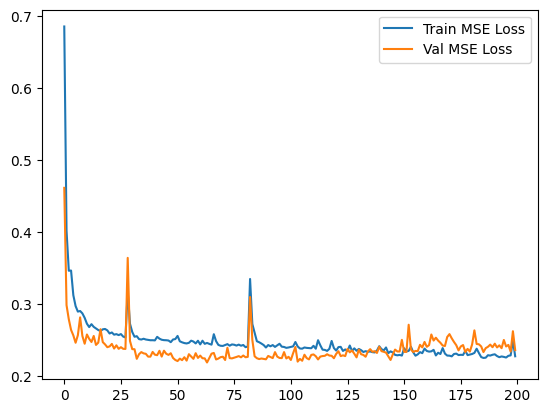

In [33]:
plt.plot(train_results["train_loss"], label="Train MSE Loss")
plt.plot(train_results["val_loss"], label="Val MSE Loss")
plt.legend()
plt.show()

In [34]:
preds = []
true_energies = []

hidden_state = model.init_hidden(128)
for embeddings, _, labels in val_loader:

    embeddings, labels = embeddings.cuda(), labels.cuda()  
    output, hidden_state = model(embeddings, hidden_state)
    preds.append(output.tolist())
    true_energies.append(labels.tolist())

preds = np.array(preds).flatten()
true_energies = np.array(true_energies).flatten()

In [35]:
mse = round(mean_squared_error(true_energies, preds), 3)
mae = round(mean_absolute_error(true_energies, preds), 3)

print(f"Val MSE: {mse}")
print(f"Val MAE: {mae}")

Val MSE: 0.236
Val MAE: 0.25


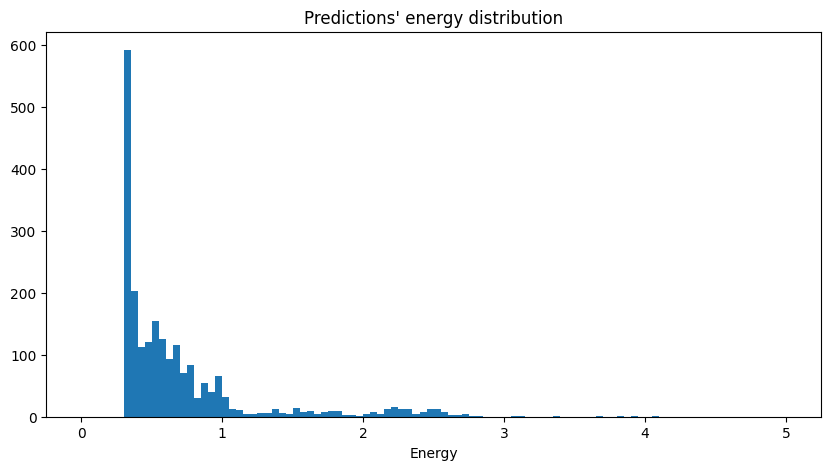

In [36]:
plt.figure(figsize=(10, 5))
plt.hist(preds, bins=100, range=(0,5))
plt.title("Predictions' energy distribution")
plt.xlabel("Energy")
plt.show()

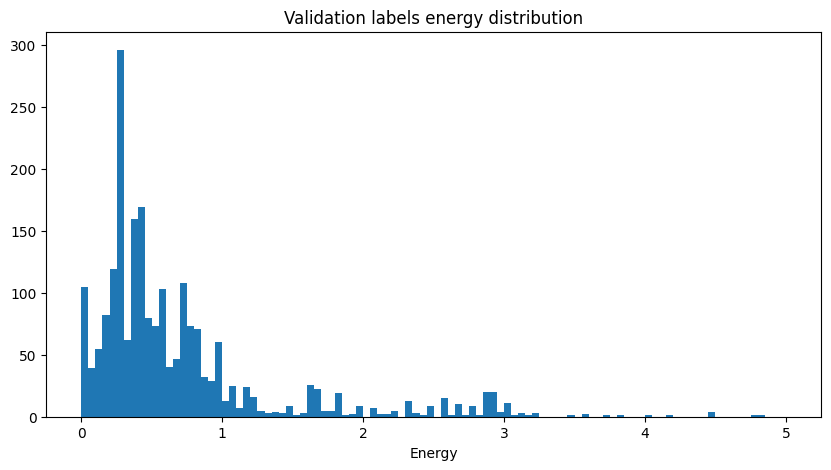

In [37]:
val_labels = true_energies

plt.figure(figsize=(10, 5))
plt.hist(val_labels, bins=100, range=(0,5))
plt.title("Validation labels energy distribution")
plt.xlabel("Energy")
plt.show()

In [38]:
median = np.median(true_energies)
std = np.std(true_energies)

print(f"Labels' median: {median}, Labels' std: {std}")

Labels' median: 0.45734401305543804, Labels' std: 0.9416572005532581


In [46]:
filtered_ids = true_energies > 0.8
filtered_true = true_energies[filtered_ids]
filtered_preds = preds[filtered_ids]

In [47]:
mse = round(mean_squared_error(filtered_true, filtered_preds), 3)
mae = round(mean_absolute_error(filtered_true, filtered_preds), 3)

print(f"Filtered MSE: {mse}")
print(f"Filtered MAE: {mae}")

Filtered MSE: 0.717
Filtered MAE: 0.535


# Simple Model

In [7]:
class Simple_Regressor(nn.Module):

    def __init__(self, emb_size: int, layers: list[int], dropout: float = 0.15, regressor_dropout: float = 0.05) -> None:
        super().__init__()
        
        self.layers_list = []

        for i, dense in enumerate(layers):
            if i == 0:
                self.layers_list.append(nn.Linear(emb_size, dense).cuda())
            else:
                self.layers_list.append(nn.Linear(layers[i-1], dense).cuda())

        self.dropout = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(regressor_dropout)
        self.regressor = nn.Linear(layers[-1], 1)

    def forward(self, x):
        
        for dense in self.layers_list:
            x = dense(x)
            if dense == self.layers_list[-1]:
                x = self.dropout2(x)
            else:
                x = self.dropout(x)

        out = self.regressor(x)

        return out

## Training Function

In [8]:
def train_simple_model(
    model: Simple_Regressor,
    train_loader: DataLoader,
    val_loader: DataLoader,
    lr: float = 1e-2,
    batch_size: int = 32,
    epochs: int = 100,
    verbose: bool = False,
    early_stopping: bool = True,
) -> dict:

    if early_stopping:
        early_stopper = EarlyStopper(patience=10, min_delta=0.05)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr, weight_decay=1e-4)

    model.cuda()

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        losses = []
        for embeddings, labels in train_loader:

            embeddings = embeddings.cuda()
            labels = labels.cuda()

            output = model(embeddings)
            loss = criterion(output.squeeze(), labels.float())

            optimizer.zero_grad()
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
            optimizer.step()
            losses.append(loss.item())

        val_loss = []
        model.eval()
        for embeddings, labels in val_loader:

            embeddings, labels = embeddings.cuda(), labels.cuda()
            output = model(embeddings)
            v_loss = criterion(output.squeeze(), labels.float())

            val_loss.append(v_loss.item())

        if verbose:
            print(
                f"Epoch: {epoch+1}/{epochs}, MSE Train Loss: {round(np.mean(losses), 5)}, MSE Val Loss: {round(np.mean(val_loss), 5)}"
            )

        train_losses.append(np.mean(losses))
        val_losses.append(np.mean(val_loss))

        if early_stopping:
            early_stopper.early_stop(val_losses[-1])

    model_training = {
        "model": model,
        "train_loss": train_losses,
        "val_loss": val_losses,
        "epochs_trained": epoch,
    }

    return model_training


## Optuna Trials

In [11]:
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "simple_nn-mean_emb-regression-study-good-dataset"
storage_name = f"sqlite:////Users/thodo/Documents/σχολη/diplomatiki/optuna-studies/{study_name}.db"
study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True, direction="minimize")

[I 2023-01-09 13:54:26,284] Using an existing study with name 'simple_nn-mean_emb-regression-study-good-dataset' instead of creating a new one.


Using an existing study with name 'simple_nn-mean_emb-regression-study-good-dataset' instead of creating a new one.
Using an existing study with name 'simple_nn-mean_emb-regression-study-good-dataset' instead of creating a new one.


In [12]:
def objective(trial):

    num_layers = trial.suggest_int("dense_layers", 1, 6)
    dense_layers = [trial.suggest_int(f"dense_{i}", 8, 256) for i in range(num_layers)]
    batch_size_exp = trial.suggest_int("batch_size_exp", 3, 7)
    lr_exp = trial.suggest_int("learning_rate_exp", -4, -2)
    dropout = trial.suggest_float("dropout", 0, 0.2)
    regressor_dropout = trial.suggest_float("regressor_dropout", 0, 0.15)

    batch_size = 2**batch_size_exp
    lr = 10**lr_exp

    data_loaders = get_data_dict(data_df=data_df, mean=True, batch_size=batch_size)
    train_loader = data_loaders["train_loader"]
    val_loader = data_loaders["val_loader"]

    emb_size = next(iter(train_loader))[0].shape[-1]

    model = Simple_Regressor(
        emb_size=emb_size,
        layers=dense_layers,
        dropout=dropout,
        regressor_dropout=regressor_dropout,
    )

    train_results = train_simple_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        lr=lr,
        epochs=200,
        batch_size=batch_size,
        early_stopping=True,
    )

    val_loss = train_results["val_loss"]

    return val_loss[-1]


study.optimize(objective, n_trials=103)

[I 2023-01-09 14:08:28,492] Trial 103 finished with value: 0.7647348031682032 and parameters: {'dense_layers': 1, 'dense_0': 61, 'batch_size_exp': 3, 'learning_rate_exp': -3, 'dropout': 0.10761429862178057, 'regressor_dropout': 0.1264597387648022}. Best is trial 55 with value: 0.43997468536312434.


Trial 103 finished with value: 0.7647348031682032 and parameters: {'dense_layers': 1, 'dense_0': 61, 'batch_size_exp': 3, 'learning_rate_exp': -3, 'dropout': 0.10761429862178057, 'regressor_dropout': 0.1264597387648022}. Best is trial 55 with value: 0.43997468536312434.
Trial 103 finished with value: 0.7647348031682032 and parameters: {'dense_layers': 1, 'dense_0': 61, 'batch_size_exp': 3, 'learning_rate_exp': -3, 'dropout': 0.10761429862178057, 'regressor_dropout': 0.1264597387648022}. Best is trial 55 with value: 0.43997468536312434.


In [13]:
study.trials_dataframe().sort_values(by="value").head(10)

,number,value,datetime_start,datetime_complete,duration,params_batch_size_exp,params_dense_0,params_dense_1,params_dense_2,params_dense_3,params_dense_4,params_dense_5,params_dense_layers,params_dropout,params_learning_rate_exp,params_regressor_dropout,state
55,55,0.439975,2023-01-09 06:17:46.434492,2023-01-09 06:30:07.847971,0 days 00:12:21.413479,3,162,NaN,NaN,NaN,NaN,NaN,1,0.184660,-3,0.000839,COMPLETE
77,77,0.481107,2023-01-09 09:51:28.306257,2023-01-09 09:57:56.392646,0 days 00:06:28.086389,4,203,NaN,NaN,NaN,NaN,NaN,1,0.153568,-3,0.017584,COMPLETE
60,60,0.483190,2023-01-09 07:21:23.597985,2023-01-09 07:27:57.998985,0 days 00:06:34.401000,4,176,NaN,NaN,NaN,NaN,NaN,1,0.172506,-3,0.006142,COMPLETE
63,63,0.493283,2023-01-09 07:48:39.618658,2023-01-09 08:01:33.299750,0 days 00:12:53.681092,3,137,NaN,NaN,NaN,NaN,NaN,1,0.058225,-3,0.003660,COMPLETE
37,37,0.511997,2023-01-09 04:05:56.400867,2023-01-09 04:09:12.563638,0 days 00:03:16.162771,5,235,NaN,NaN,NaN,NaN,NaN,1,0.167221,-3,0.140379,COMPLETE
48,48,0.532418,2023-01-09 04:48:09.741557,2023-01-09 05:00:30.477013,0 days 00:12:20.735456,3,158,NaN,NaN,NaN,NaN,NaN,1,0.189842,-3,0.019822,COMPLETE
22,22,0.532783,2023-01-09 03:07:39.123335,2023-01-09 03:10:55.686098,0 days 00:03:16.562763,5,221,NaN,NaN,NaN,NaN,NaN,1,0.173118,-3,0.121949,COMPLETE
47,47,0.540323,2023-01-09 04:41:54.784896,2023-01-09 04:48:09.722564,0 days 00:06:14.937668,4,160,NaN,NaN,NaN,NaN,NaN,1,0.153256,-3,0.134953,COMPLETE
92,92,0.541284,2023-01-09 11:48:51.572990,2023-01-09 12:02:42.010988,0 days 00:13:50.437998,3,60,NaN,NaN,NaN,NaN,NaN,1,0.151706,-3,0.132688,COMPLETE
64,64,0.541902,2023-01-09 08:01:33.318743,2023-01-09 08:07:45.494753,0 days 00:06:12.176010,4,112,NaN,NaN,NaN,NaN,NaN,1,0.044553,-3,0.000672,COMPLETE


In [14]:
print(f"Best simple-regressor-model params: {study.best_params}, achieving val MSE: {study.best_value}")

Best simple-regressor-model params: {'batch_size_exp': 3, 'dense_0': 162, 'dense_layers': 1, 'dropout': 0.18466029305173945, 'learning_rate_exp': -3, 'regressor_dropout': 0.0008387692491181251}, achieving val MSE: 0.43997468536312434


## Results

In [16]:
batch_size = 8

data_loaders = get_data_dict(data_df=data_df, mean=True, batch_size=batch_size)
train_loader = data_loaders["train_loader"]
val_loader = data_loaders["val_loader"]

emb_size = next(iter(train_loader))[0].shape[-1]

model = Simple_Regressor(
    emb_size=emb_size, layers=[162], regressor_dropout=8e-4
)
train_results = train_simple_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    lr=1e-3,
    epochs=200,
    batch_size=batch_size,
    verbose=True,
    early_stopping=True,
)

Epoch: 1/200, MSE Train Loss: 0.72924, MSE Val Loss: 0.47736
Epoch: 2/200, MSE Train Loss: 0.65406, MSE Val Loss: 0.46395
Epoch: 3/200, MSE Train Loss: 0.62942, MSE Val Loss: 0.45701
Epoch: 4/200, MSE Train Loss: 0.61366, MSE Val Loss: 0.4535
Epoch: 5/200, MSE Train Loss: 0.60125, MSE Val Loss: 0.45013
Epoch: 6/200, MSE Train Loss: 0.59156, MSE Val Loss: 0.44791
Epoch: 7/200, MSE Train Loss: 0.58372, MSE Val Loss: 0.44725
Epoch: 8/200, MSE Train Loss: 0.57721, MSE Val Loss: 0.44579
Epoch: 9/200, MSE Train Loss: 0.57115, MSE Val Loss: 0.44477
Epoch: 10/200, MSE Train Loss: 0.56547, MSE Val Loss: 0.44479
Epoch: 11/200, MSE Train Loss: 0.56202, MSE Val Loss: 0.44407
Epoch: 12/200, MSE Train Loss: 0.55817, MSE Val Loss: 0.44426
Epoch: 13/200, MSE Train Loss: 0.55369, MSE Val Loss: 0.44437
Epoch: 14/200, MSE Train Loss: 0.55049, MSE Val Loss: 0.44324
Epoch: 15/200, MSE Train Loss: 0.54899, MSE Val Loss: 0.44334
Epoch: 16/200, MSE Train Loss: 0.54695, MSE Val Loss: 0.44417
Epoch: 17/200, MSE

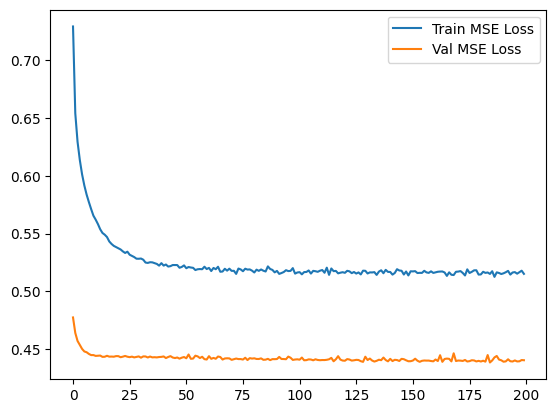

In [17]:
plt.plot(train_results["train_loss"], label="Train MSE Loss")
plt.plot(train_results["val_loss"], label="Val MSE Loss")
plt.legend()
plt.show()

In [18]:
preds = []
true_energies = []

for embeddings, labels in val_loader:

    embeddings, labels = embeddings.cuda(), labels.cuda()  
    output = model(embeddings)
    preds.append(output.tolist())
    true_energies.append(labels.tolist())

preds = np.array(preds).flatten()
true_energies = np.array(true_energies).flatten()

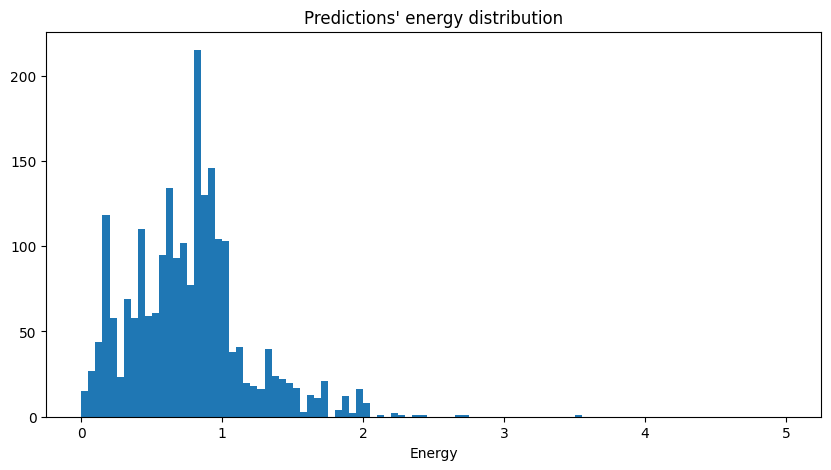

In [19]:
plt.figure(figsize=(10, 5))
plt.hist(preds, bins=100, range=(0,5))
plt.title("Predictions' energy distribution")
plt.xlabel("Energy")
plt.show()

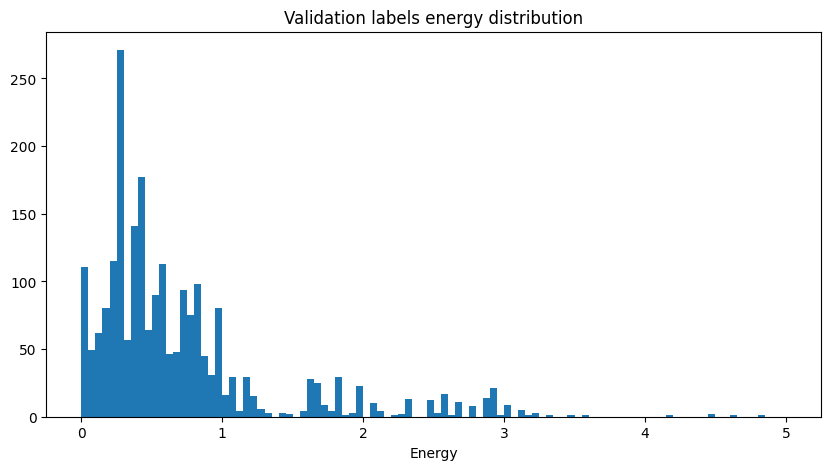

In [20]:
val_labels = true_energies

plt.figure(figsize=(10, 5))
plt.hist(val_labels, bins=100, range=(0,5))
plt.title("Validation labels energy distribution")
plt.xlabel("Energy")
plt.show()